## Ethiopia Nutrition and Demand System

In [17]:
import pandas as pd
import cfe.regression as rgsn

### From Sheet to DataFrame to Regression Object



In [18]:
Tanzania_Data = '1tlNUxe2hY2DAOsv6u7R7yC_CiBcr05cXXQiRWBlEHEo'
Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

In [19]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

x = read_sheets(Tanzania_Data,sheet='Food Expenditures (2020-21)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Tanzania_Data,sheet='Food Prices (2020-21)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('kg',level="u").squeeze().unstack('j')

# Get intersection of goods we have prices *and* expenditures for:
jidx = p.columns.intersection(x.index.levels[-1])

# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(Tanzania_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [20]:
grouped_expenditure = x.groupby('j')['Expenditure'].sum().reset_index()

# Optional: Sort by expenditure in descending order
grouped_expenditure = grouped_expenditure.sort_values(by='Expenditure', ascending=False)

# Display the result
print(grouped_expenditure)

KeyError: 'Column not found: Expenditure'

This gives a dataframe of household characteristics $d$ with a simple structure.



In [21]:
d.head()

k                                Males 00-03  Females 00-03  Males 04-08  \
i        t       m                                                         
0001-001 2012-13 Mainland Rural            0              0            0   
         2014-15 Mainland Rural            0              0            0   
0001-004 2014-15 Mainland Rural            1              0            0   
0002-001 2012-13 Mainland Rural            0              2            0   
         2014-15 Mainland Rural            2              0            0   

k                                Females 04-08  Males 09-13  Females 09-13  \
i        t       m                                                           
0001-001 2012-13 Mainland Rural              0            0              0   
         2014-15 Mainland Rural              0            0              0   
0001-004 2014-15 Mainland Rural              0            0              0   
0002-001 2012-13 Mainland Rural              2            0              0   
         2014-15 Mainland Rural              4            0              0   

k                                Males 14-18  Females 14-18  Males 19-30  \
i        t       m                                                         
0001-001 2012-13 Mainland Rural            0              0            4   
         2014-15 Mainland Rural            0              0            1   
0001-004 2014-15 Mainland Rural            0              0            1   
0002-001 2012-13 Mainland Rural            0              0            0   
         2014-15 Mainland Rural            0              0            0   

k                                Females 19-30  Males 31-50  Females 31-50  \
i        t       m                                                           
0001-001 2012-13 Mainland Rural              0            0              0   
         2014-15 Mainland Rural              0            1              0   
0001-004 2014-15 Mainland Rural              1            0              0   
0002-001 2012-13 Mainland Rural              2            2              0   
         2014-15 Mainland Rural              2            2              0   

k                                Males 51-99  Females 51-99  log HSize  
i        t       m                                                      
0001-001 2012-13 Mainland Rural            2              2   2.079442  
         2014-15 Mainland Rural            1              1   1.386294  
0001-004 2014-15 Mainland Rural            0              0   1.098612  
0002-001 2012-13 Mainland Rural            0              0   2.079442  
         2014-15 Mainland Rural            0              0   2.302585

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [22]:
y.head()

i            t        m               j             
1009-001-01  2020-21  Mainland Rural  Beef              8.699515
                                      Bread             7.824046
                                      Cooking Oil       8.517193
                                      Dairy Products    8.853665
                                      Eggs              7.313220
Name: Expenditure, dtype: float64

Finally, construct a regression object:



In [23]:
from cfe import Regression
r = rgsn.Regression(y=y,d=d)

#import matplotlib.pyplot as plt



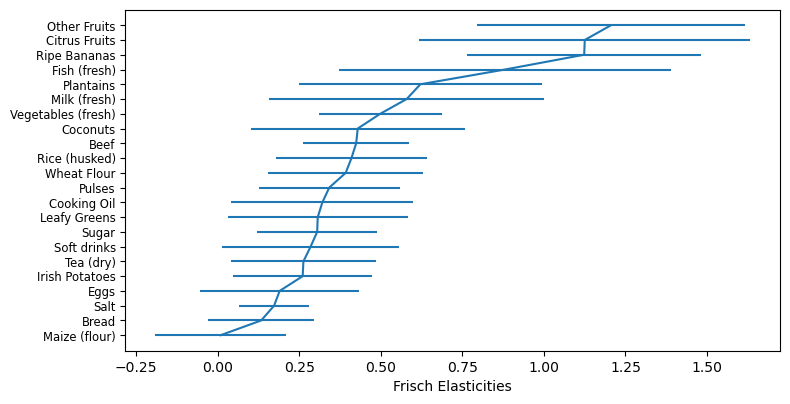

In [24]:
ax = r.graph_beta()

### Demand System



Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [25]:
fct = read_sheets(Tanzania_Data,sheet='FCT')
fct['j'] = fct['j'].str.title()
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [26]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,Iron,Zinc
j,,,,,,,,,,,,
Beef,3230,249,0,0,0,0,3,19,40,230,17,41
Bottled Beer,410,3,0,0,0,0,1,0,50,60,0,0
Bread,2740,80,0,0,0,0,0,0,100,270,5,9
Butter,8760,3,9250,20,30,0,0,0,80,10,1,0
Canned Milk/Milk Powder,4960,263,4070,0,0,70,4,30,8510,810,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...
"Wheat, Barley Grain And Other Cereals",3490,123,0,0,10,0,2,0,260,920,28,20
"Wheat, Barley, Other Grains",3490,123,0,0,10,0,2,0,260,920,28,20
Wild Birds And Insects,0,0,0,0,0,0,0,0,0,0,0,0


We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



In [27]:
rdi = read_sheets(Uganda_Data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Pre-estimated Demand Systems



#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [29]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [30]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [31]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beef,Bread,Citrus Fruits,Coconuts,Cooking Oil,Eggs,Fish (fresh),Irish Potatoes,Leafy Greens,Maize (flour),...,Plantains,Pulses,Rice (husked),Ripe Bananas,Salt,Soft drinks,Sugar,Tea (dry),Vegetables (fresh),Wheat Flour
i,t,m,,,,,,,,,,,,,,,,,,,,,
1009-001-01,2020-21,Mainland Rural,0.989583,1.137633,1.657478,2.702072,0.605272,0.366246,1.002811,2.375649,1.451940,4.814558,...,5.746730,1.654494,3.832544,1.263991,0.181394,1.102335,0.806083,0.022916,1.559209,2.289599
1025-001-02,2020-21,Mainland Other Urban,0.515797,0.702638,0.189089,1.194587,0.417571,0.212386,0.329356,1.460718,0.737804,1.399090,...,1.100191,0.613303,1.289250,0.429744,0.083164,0.722737,0.434293,0.016491,0.953149,0.592479
1039-001-01,2020-21,Mainland Other Urban,0.965758,1.776402,1.461940,1.844746,0.613828,0.419162,0.988730,3.054115,1.351403,3.241577,...,3.187781,0.839517,4.421572,1.376453,0.152590,0.889718,0.783160,0.033906,1.794291,1.160936
1078-001-01,2020-21,Mainland Rural,0.857966,1.223072,0.976868,1.573988,0.585294,0.832285,0.648790,2.552069,1.305202,7.380161,...,7.725919,1.455162,4.423739,0.904991,0.229446,1.196172,1.184373,0.026623,1.186520,2.901941
1102-001-01,2020-21,Mainland Rural,0.413608,0.796540,0.236203,0.872914,0.361398,0.429770,0.218257,1.748611,0.689655,7.398177,...,3.265235,1.119246,1.948739,0.374010,0.175126,1.217604,0.689927,0.022557,0.576505,1.495171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9760-001-99,2020-21,Mainland Other Urban,1.213129,0.821142,0.946051,3.841946,0.721973,0.522983,2.181230,1.785612,1.070915,2.963595,...,3.660985,1.150730,5.030483,1.296099,0.165125,1.221811,0.996928,0.029770,2.118216,1.328551
9772-001-99,2020-21,Mainland Other Urban,0.756884,1.163829,0.377360,2.078840,0.624736,0.358316,0.544532,1.857763,0.966110,4.458531,...,2.275306,0.910732,3.373506,0.281346,0.162178,0.802659,0.929577,0.023727,1.211309,1.740650
9784-001-99,2020-21,Mainland Other Urban,0.727671,0.978711,0.124131,1.618206,0.398197,0.477144,0.348709,1.152752,0.623820,3.170141,...,1.436061,0.508042,2.286853,0.163032,0.127070,0.612063,0.539413,0.019111,0.824053,0.656075


Finally, define a function to change a single price in the vector $p$:



In [32]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [33]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Beef Demanded')

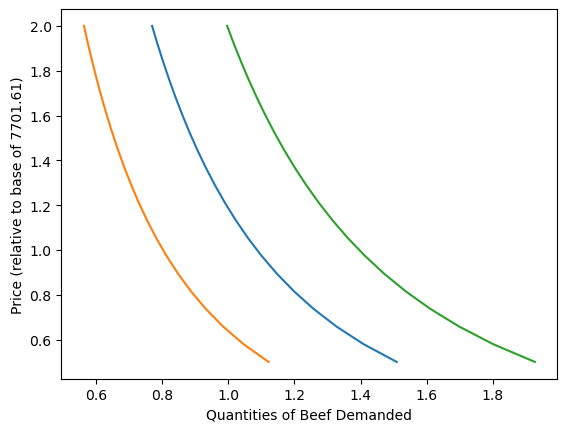

In [34]:
import matplotlib.pyplot as plt

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Matoke for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -8.59E+09.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

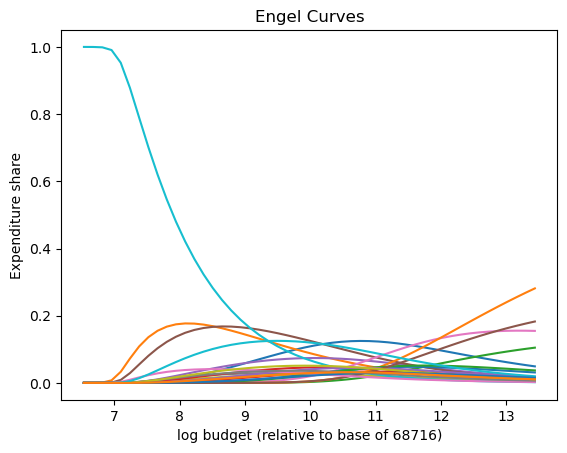

In [35]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [36]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,Iron,Zinc
j,,,,,,,,,,,,
Beef,3230,249,0,0,0,0,3,19,40,230,17,41
Bottled Beer,410,3,0,0,0,0,1,0,50,60,0,0
Bread,2740,80,0,0,0,0,0,0,100,270,5,9
Butter,8760,3,9250,20,30,0,0,0,80,10,1,0
Canned Milk/Milk Powder,4960,263,4070,0,0,70,4,30,8510,810,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...
"Wheat, Barley Grain And Other Cereals",3490,123,0,0,10,0,2,0,260,920,28,20
"Wheat, Barley, Other Grains",3490,123,0,0,10,0,2,0,260,920,28,20
Wild Birds And Insects,0,0,0,0,0,0,0,0,0,0,0,0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [37]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Bread', 'Citrus Fruits', 'Coconuts', 'Cooking Oil', 'Eggs',
       'Irish Potatoes', 'Plantains', 'Ripe Bananas', 'Salt', 'Sugar'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [38]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,1009-001-01,1025-001-02,1039-001-01,1078-001-01,1102-001-01,1142-001-01,1196-001-01,1213-001-01,1232-001-01,1248-001-01,...,9700-001-99,9712-001-99,9724-001-99,9736-001-99,9748-001-99,9760-001-99,9772-001-99,9784-001-99,9796-001-99,9808-001-99
t,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,...,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21,2020-21
m,Mainland Rural,Mainland Other Urban,Mainland Other Urban,Mainland Rural,Mainland Rural,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,Dar Es Salaam,...,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban,Mainland Other Urban
n,,,,,,,,,,,,,,,,,,,,,
Energy,21673.388203,12127.882599,23517.839020,22804.739282,13179.631233,15102.348519,21029.579992,22906.910325,22887.922554,11494.745271,...,18920.404944,29702.792510,21003.979136,22512.482026,20257.100960,23651.896405,19223.099221,14286.733428,24567.934046,25840.868010
Protein,497.580576,267.038833,561.669593,548.935876,294.804164,310.084158,447.397674,420.151828,483.946011,250.090857,...,425.309239,594.269184,466.667757,398.618260,496.899977,545.866812,404.407609,385.155251,573.779049,498.628274
Vitamin A,3137.113867,1748.342569,3553.460098,6846.805078,3511.250887,2218.598921,3578.340891,1915.905121,3590.212626,1667.342816,...,5120.517214,2025.503456,3767.111961,3109.004662,2978.225787,4350.731441,2940.991985,3879.685947,4627.046732,3504.938698
Vitamin D,29.299713,16.990846,33.532951,66.582775,34.381574,20.803799,34.057158,17.869075,34.159687,16.060944,...,50.361435,17.231828,36.473919,30.259248,27.933261,41.838661,28.665312,38.171501,44.869676,33.470607
Vitamin E,173.810115,106.721268,220.523676,194.392274,129.740306,105.932609,159.115631,181.368272,75.349774,68.992097,...,121.955576,206.768816,188.957794,173.296989,124.154990,138.611465,138.165160,90.922246,228.936800,231.509489
Vitamin C,1457.321898,421.244402,1481.092603,1086.898996,491.697308,900.657287,967.158099,1052.402356,774.425112,404.930724,...,407.420970,2008.916066,886.996753,716.784455,1118.637079,984.710661,590.810214,310.567173,993.883659,1212.895813
Vitamin B-6,27.776717,14.530023,32.920479,28.364352,16.932422,18.111807,31.138597,27.095555,20.928078,11.145547,...,16.813863,41.866521,27.104447,21.735710,24.768060,24.361050,18.211003,12.937112,34.535488,33.583353


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [39]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

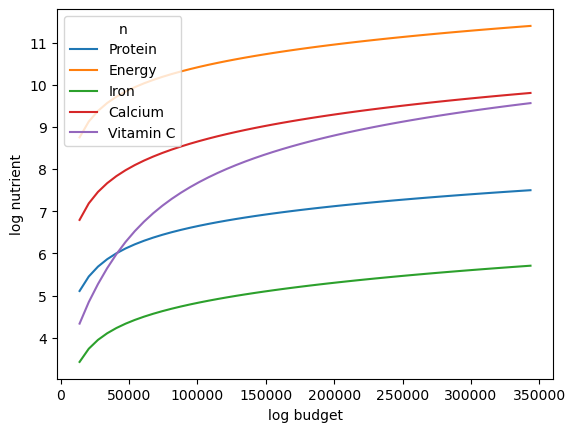

In [40]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

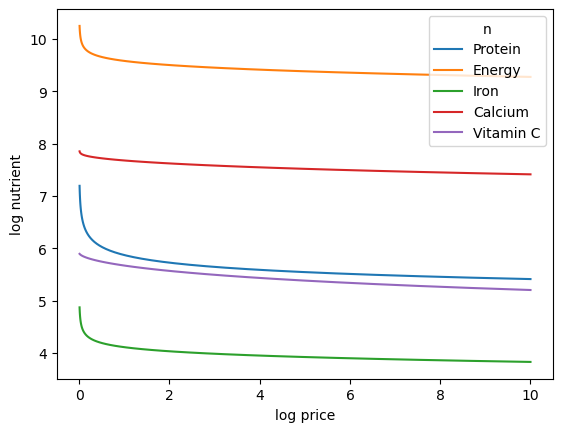

In [41]:
USE_GOOD = 'Beef'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [42]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [43]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           9638.461538
Protein           216.948718
Fiber             134.938462
Folate           1813.846154
Calcium          5838.974359
Carbohydrate      713.000000
Iron               59.161538
Magnesium        1559.025641
Niacin             69.071795
Phosphorus       4342.358974
Potassium       23955.128205
Riboflavin          5.420769
Thiamin             5.260513
Vitamin A        3613.846154
Vitamin B-12       10.883077
Vitamin B-6         6.031282
Vitamin C         328.807692
Vitamin E          67.587179
Vitamin K         434.935897
Zinc               43.776923
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [44]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



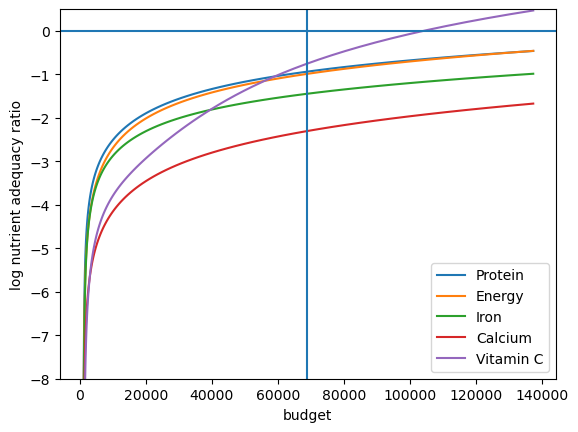

In [46]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)
plt.ylim(-8,.5)
from IPython.display import clear_output
clear_output()

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

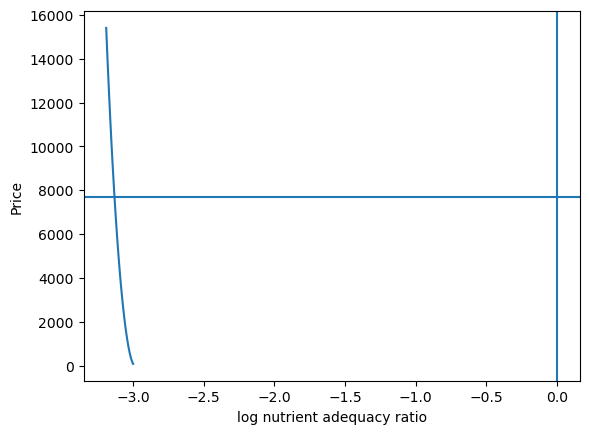

In [47]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.80E+16.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.52E+13.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -6.87E+10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

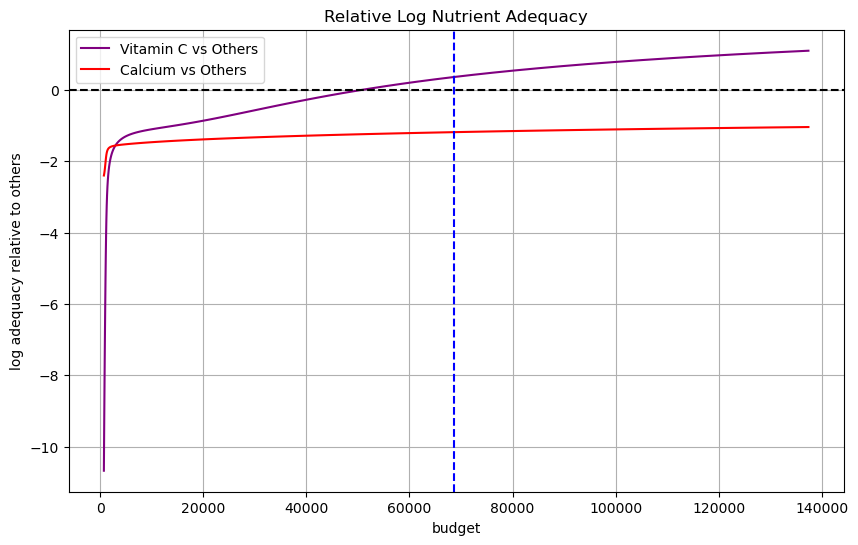

In [48]:
X = np.geomspace(.01 * xref, 2 * xref, 100)

# Compute nutrient adequacy ratios for all nutrients
nutrient_logs = pd.DataFrame({
    x: np.log(nutrient_adequacy_ratio(x, pbar, dbar))[UseNutrients]
    for x in X
}).T  # Shape: (100 budgets x 5 nutrients)

# Extract Vitamin C and Calcium columns
vitamin_c = nutrient_logs['Vitamin C']
calcium = nutrient_logs['Calcium']

# Compute average of all nutrients *excluding* Vitamin C and Calcium
other_nutrients = [n for n in UseNutrients if n not in ['Vitamin C', 'Calcium']]
others_avg = nutrient_logs[other_nutrients].mean(axis=1)

# Compute relative log nutrient adequacy
vitamin_c_rel = vitamin_c - others_avg
calcium_rel = calcium - others_avg

# Plot the significance graph
plt.figure(figsize=(10, 6))
plt.plot(X, vitamin_c_rel, label='Vitamin C vs Others', color='purple')
plt.plot(X, calcium_rel, label='Calcium vs Others', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(xref, color='blue', linestyle='--')
plt.xlabel('budget')
plt.ylabel('log adequacy relative to others')
plt.title('Relative Log Nutrient Adequacy')
plt.legend()
plt.grid(True)
plt.show()
